# Quantum circuit dataset construction

Functions to construct a dataset. Here we define the tokenization (encoding and decoding).

In [ ]:
#| default_exp platform.qcircuit_dataset_construction

In [ ]:
#| export
from genQC.imports import *
from genQC.platform.simulation.qcircuit_sim import *
import genQC.dataset.dataset_helper as dahe

import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.circuit.gate import Gate
import qiskit.circuit.library as ql

## Tokenizer: encoding and decoding

In [ ]:
#| export
def get_target_control_qubits(qc: QuantumCircuit, gate: Gate):
    acts_on_cnt = gate.operation.num_qubits
    acts_on     = [qc.find_bit(qubit).index for qubit in gate.qubits]      # order: (*control_qubits, *target_qubits)

    assert acts_on_cnt == len(acts_on), "error in: acts_on_cnt == len(acts_on)"

    num_ctrl_qubits = gate.operation.num_ctrl_qubits if hasattr(gate.operation, "num_ctrl_qubits") else 0 
    num_targ_qubits = acts_on_cnt - num_ctrl_qubits

    control_qubits, target_qubits = acts_on[:-num_targ_qubits], acts_on[-num_targ_qubits:]   
    
    return control_qubits, target_qubits  

In [ ]:
#| export
def encode_circuit(qc: QuantumCircuit, num_of_qubits, gate_classes: dict, max_gates: int, sign_labels={"control_qubits":-1, "target_qubits":+1}, return_params=False):
    # circuit tensor
    #  [qbits, time]  .. in +- gate_number   
    #                         0 for empty
       
    tensor = torch.zeros((num_of_qubits, max_gates), dtype=torch.int32) 
    params = []
    
    for t, gate in enumerate(qc.data):
        params.append(gate.operation.params)
        
        gate_id = gate_classes[gate.operation.name]  #for new tensor just use this as the abs(T) and then assign the sign dep on the c/t
                         
        control_qubits, target_qubits = get_target_control_qubits(qc, gate)  
                       
        for bit in control_qubits:
            tensor[bit, t] = gate_id * sign_labels["control_qubits"]
        
        for bit in target_qubits:
            tensor[bit, t] = gate_id * sign_labels["target_qubits"]

    if return_params: 
        num_of_max_params = max(len(para) for para in params)
        params_tensor     = torch.zeros((num_of_max_params, max_gates), dtype=torch.float32)
        
        for t, para in enumerate(params):
            params_tensor[:len(para), t] = torch.tensor(para)
                     
        return tensor, params_tensor
        
    return tensor

In [ ]:
#| export
def decode_circuit(enc_tensor: torch.Tensor, gate_pool: list[Gate], place_barrier=True, sign_labels={"control_qubits":-1, "target_qubits":+1}, params_tensor=None):  
    # should have dim 2, [bits, sequence]
    #minus ... control_qubits
    #plus  ... target_qubits

    assert enc_tensor.ndim == 2, f"{enc_tensor.shape=}"
    num_of_qubits, time = enc_tensor.shape
        
    gate_qiskit_classes = {(i+1):x for i,x in enumerate(gate_pool)}
    
    qc = QuantumCircuit(num_of_qubits)  
          
    for t in range(time):         
        enc_time_slice = enc_tensor[:, t] # only contains all bits at time t   
                      
        for gate_index,gate_qiskit_class in gate_qiskit_classes.items():                       
            target_qubits  = (enc_time_slice == (sign_labels["target_qubits"] *gate_index)).nonzero()
            control_qubits = (enc_time_slice == (sign_labels["control_qubits"]*gate_index)).nonzero()
                       
            if target_qubits.nelement() > 0:
                num_of_paramters = get_number_of_gate_params(gate_qiskit_class)   
                if exists(params_tensor) and num_of_paramters > 0 : params = params_tensor[:num_of_paramters, t].tolist()
                else:                                               params = [0] * num_of_paramters
                
                qc.append(gate_qiskit_class(*params), [*control_qubits.tolist(), *target_qubits.tolist()], [])        
                if place_barrier: qc.barrier()
                break #break on first hit, per def only one gate allowed per t
                
            elif control_qubits.nelement() > 0: #no target but control means error
                raise RuntimeError("control_qubits.nelement() > 0")
            #else we are fine with tensor that have time steps with no action!

    return qc

## Dataset generation

### Totally random SRV circuits

In [ ]:
#| export
def get_rnd_encoded_circuit(num_of_qubits, min_gates, max_gates, gate_pool, gate_classes, rng, optimized=True, return_params=False):    
    qc = rnd_circuit(num_of_qubits, rng.integers(min_gates, max_gates+1), gate_pool, rng)  
    if optimized: qc = optimize_circuit(qc, gate_pool)        
    svr = schmidt_rank_vector(qi.DensityMatrix(qc))
    
    if return_params:
        qc_tensor, params_tensor = encode_circuit(qc, num_of_qubits, gate_classes, max_gates, return_params=return_params)  
        return qc, qc_tensor, svr, params_tensor
    
    qc_tensor = encode_circuit(qc, num_of_qubits, gate_classes, max_gates, return_params=return_params)     
    return qc, qc_tensor, svr 

In [ ]:
#| export
def get_rnd_encoded_circuits(samples, num_of_qubits=3, min_gates=3, max_gates=10, gate_pool=[ql.HGate, ql.CXGate], optimized=True, silent=False, return_params=False):
    gate_classes = gate_pool_to_gate_classes(gate_pool) #{x().name:(i+1) for i,x in enumerate(gate_pool)}
    
    rng = np.random.default_rng()
    
    data   = []
    label  = []
    params = []
    
    for i in tqdm(range(samples), disable=silent):            
        if return_params:
            qc, qc_tensor, svr, params_tensor = get_rnd_encoded_circuit(num_of_qubits, min_gates, max_gates, gate_pool, gate_classes, rng, optimized, return_params=return_params)  
            params.append(params_tensor)
            
        else:
             qc, qc_tensor, svr = get_rnd_encoded_circuit(num_of_qubits, min_gates, max_gates, gate_pool, gate_classes, rng, optimized, return_params=return_params)  
            
        data.append(qc_tensor)
        label.append(svr)
    
    if return_params: return data, label, params
    return data, label

Encode:


  0%|          | 0/1 [00:00<?, ?it/s]

enc_i=tensor([[-2,  0, -2,  3,  3,  0],
        [ 2,  1,  2, -3, -3,  0],
        [ 0,  0,  0,  0,  0,  1]], dtype=torch.int32)
y_i=[2, 2, 1]
params_i=tensor([[0.0000, 0.0000, 0.0000, 2.2710, 4.8585, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0304, 1.1044, 0.0000],
        [0.0000, 0.0000, 0.0000, 3.0486, 4.9504, 0.0000]])
Decode:


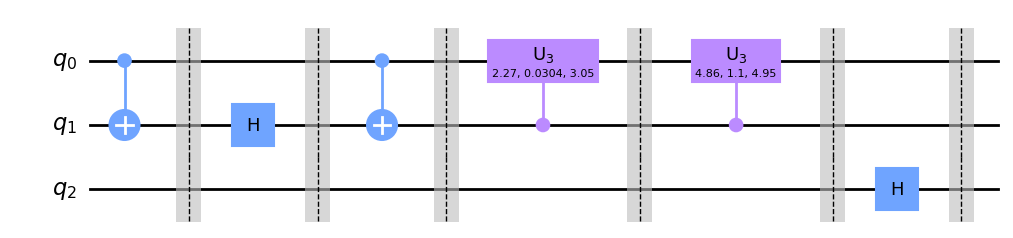

In [ ]:
gate_pool=[ql.HGate, ql.CXGate, ql.CU3Gate, ql.CRXGate]

print("Encode:")
enc_t, y, params = get_rnd_encoded_circuits(samples=1, num_of_qubits=3, min_gates=6, max_gates=6, gate_pool=gate_pool, optimized=True, return_params=True)

for enc_i, y_i, params_i in zip(enc_t, y, params):
    print(f"{enc_i=}")
    print(f"{y_i=}")
    print(f"{params_i=}")

print("Decode:")
qc = decode_circuit(enc_t[0], gate_pool=gate_pool, params_tensor=params[0])
display(qc.draw("mpl"))

In [ ]:
#| export
def gen_qc_dataset(samples, num_of_qubits, min_gates, max_gates, gate_pool, optimized, silent=False):
    tensor, srv = get_rnd_encoded_circuits(samples, num_of_qubits, min_gates, max_gates, gate_pool, optimized, silent)

    # make sure we have unique circuits
    tensor = torch.stack(tensor, dim=0)
    tensor_unique, tensor_indices = dahe.get_unique_elements_indices(tensor)
    
    if not silent: print(f"Generated unique circuits: {tensor_unique.shape[0]}")
    
    #--------------------------
    #select uniques only
    
    x = tensor[tensor_indices]
    y = torch.Tensor(srv).type(torch.int32)[tensor_indices] #leave as tensor, treat as 2D condition, combine cond into one large (each cat)
    
    return x,y

### Specific random SRV circuit

In [ ]:
#| export
def get_specific_rnd_srv_circuit(srv, requested_length, gate_pool, max_i=2000, silent=True, fix_length_after_optimizing=True, requested_length_tolerance=0):
    rng = np.random.default_rng()
    
    num_of_qubits = len(srv) 
    is_srv        = None

    if requested_length < sum(srv)-num_of_qubits: return None   #not possible to generate this srv, to few gates
    
    i = 0
    while is_srv != srv:                  # brute-force sample a SRV
        qc = rnd_circuit(num_of_qubits, requested_length, gate_pool, rng)  
        qc = optimize_circuit(qc, gate_pool)        

        if i > max_i: 
            if not silent: print(f"Max i reached: {srv=}  {requested_length=}  {requested_length_tolerance=}  {max_i=}")
            return None #raise RuntimeError("max i reached")     
        i += 1

        #---------------
        if fix_length_after_optimizing and len(qc.data) < requested_length-requested_length_tolerance:
                continue
        
        is_srv = schmidt_rank_vector(qi.DensityMatrix(qc)) 
       
    return qc

### Unitary dataset

In [ ]:
#| export
def gen_compilation_rndGates_dataset(samples, num_of_qubits, min_gates, max_gates, gate_pool, min_sub_gate_pool_cnt=1, silent=False):
    '''Samples rnd circuit with a rnd subset of gates and return qc with gate label and unitary'''

    gate_classes = {x().name:(i+1) for i,x in enumerate(gate_pool)} #+1 for empty! global gate classes so we fix the indices! 1...H   2...CX   so on

    #-------------------------------
    
    rng     = np.random.default_rng()
    n       = len(gate_pool) + 1
    c_range = np.arange(n-1)
          
    tensor = []
    label  = []
    U      = []
    
    for i in tqdm(range(samples), disable=silent):
        sub_gate_pool_cnt = rng.integers(min_sub_gate_pool_cnt, n)       
        sub_gate_pool_ind = rng.choice(c_range, size=sub_gate_pool_cnt, replace=False)         
        sub_gate_pool     = [gate_pool[ind] for ind in sub_gate_pool_ind]  # pick random subeset of gates
              
        qc, qc_tensor, svr = get_rnd_encoded_circuit(num_of_qubits, min_gates, max_gates, sub_gate_pool, gate_classes, rng, optimized=True)
    
        tensor.append(qc_tensor)
        label.append(f"Compile using: {[x().name for x in sub_gate_pool]}")
        U.append(qi.Operator(qc).to_matrix())
        
    #-------------------------------
        
    # make sure we have unique circuits
    tensor = torch.stack(tensor, dim=0)
    tensor_unique, tensor_indices = dahe.get_unique_elements_indices(tensor)
    
    if not silent: print(f"generated unique circuits: {tensor_unique.shape[0]}")
    
    #--------------------------
    #select uniques only
    
    x = tensor[tensor_indices]
    y = [label[i] for i in tensor_indices.tolist()]
    U = [    U[i] for i in tensor_indices.tolist()]
    
    return x,y,U  

  0%|          | 0/1 [00:00<?, ?it/s]

generated unique circuits: 1

y Label >>> Compile using: ['x'] <<<

tensor([[0, 0, 0, 0],
        [4, 0, 0, 0],
        [0, 4, 4, 4]], dtype=torch.int32)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

Decoded:


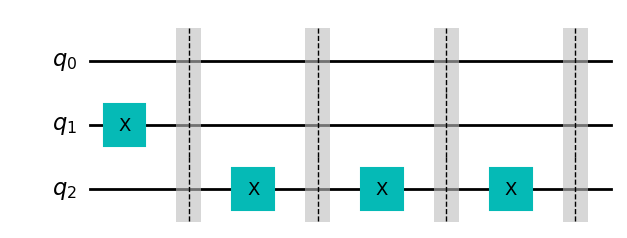

In [ ]:
gate_pool=[ql.HGate, ql.CXGate, ql.ZGate, ql.XGate, ql.CCXGate]

enc_t, y, U = gen_compilation_rndGates_dataset(samples=1, num_of_qubits=3, min_gates=3, max_gates=4, gate_pool=gate_pool)

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

print(f"\ny Label >>> {y[0]} <<<")
print(f"\n{enc_t[0]}")
print(f"\n{U[0]}")
print("\nDecoded:")
qc = decode_circuit(enc_t[0], gate_pool=gate_pool)
display(qc.draw("mpl"))

### Graph states dataset

In [ ]:
#place all h on all bist then only cz

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()